In [40]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
%matplotlib inline

import pickle

exec(open('justins_utils.py').read())
exec(open('justins_pipeline.py').read())

# Train Model

In [41]:
# define paths where data is located
post_results_name = 'NCAATourneyCompactResults'
reg_results_name = 'RegularSeasonDetailedResults'
seeds_name = 'NCAATourneySeeds'
ordinals_name = 'MasseyOrdinals'

template = 'Data/DataFiles/{}.csv'

# call full pipeline using paths
df_pipe = full_pipeline(post_results=template.format(post_results_name),
                        reg_results_path=template.format(reg_results_name),
                        seeds_path=template.format(seeds_name),
                        ordinal_path=template.format(ordinals_name))


# load train and test indices
permut_tr  = pickle.load(open('pickles/permut_tr', 'rb'))
permut_tst = pickle.load(open('pickles/permut_tst', 'rb'))

# extract training and test data
df_pipe_tr  = df_pipe.iloc[permut_tr]
df_pipe_tst = df_pipe.iloc[permut_tst]

# convert to matrix representation
X, y = get_X_y(df_pipe_tr)
X_tst, y_tst = get_X_y(df_pipe_tst)

X.shape      = (882, 32) 
y.shape      = (882,)
X.shape      = (99, 32) 
y.shape      = (99,)


In [42]:
X, y = get_X_y(df_pipe)

X.shape      = (981, 32) 
y.shape      = (981,)


In [43]:
# normalize input (if not already normalized)
X = StandardScaler().fit_transform(X)
X_tst = StandardScaler().fit_transform(X_tst)

# sanity checks
print('{:<12} = {}'.format('X.shape', X.shape), '\n'
      '{:<12} = {}'.format('y.shape', y.shape),
      '\n\n'
      '{:<12} = {}'.format('X_tst.shape', X_tst.shape), '\n'
      '{:<12} = {}'.format('y_tst.shape', y_tst.shape))

X.shape      = (981, 32) 
y.shape      = (981,) 

X_tst.shape  = (99, 32) 
y_tst.shape  = (99,)


In [44]:
def random_grid_cv(X, y, estimator, hyperparams, scoring='neg_log_loss', cv=5, report=True, verbose=1):
    gs = RandomizedSearchCV(estimator=estimator,
                            param_distributions=hyperparams, 
                            scoring=scoring, 
                            cv=cv, 
                            verbose=verbose)
    
    # search hyperparameter space
    gs.fit(X, y)
    
    # avoid deprecation warnings
    scores_of_interest = ['rank_test_score', 'mean_test_score', 'std_test_score']
    score_dict = { key:value for key, value in gs.cv_results_.items() if key in scores_of_interest }
    
    # generate DataFrames from scores and parameters
    score_df = pd.DataFrame(score_dict)[scores_of_interest]
    param_df = pd.DataFrame(gs.cv_results_['params'])
    
    # merge scores and parameters
    score_df = score_df.merge(param_df, left_index=True, right_index=True).sort_values(by='rank_test_score')
    
    if report:
        print(gs.best_estimator_)
        display(score_df)
    
    return gs.best_estimator_, score_df

In [45]:
lr_hyperparams = {'penalty': ['l1', 'l2'], 
                  'C': np.logspace(-3, 2, base=10, num=10)}

lr_best, lr_scores = random_grid_cv(X, y, LogisticRegression(), lr_hyperparams)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


,rank_test_score,mean_test_score,std_test_score,C,penalty
7,1,-0.544505,0.032999,0.166810,l2
0,2,-0.545517,0.026901,0.012915,l2
4,3,-0.545971,0.029528,0.166810,l1
9,4,-0.546672,0.032227,0.599484,l1
1,5,-0.549012,0.033646,0.599484,l2
3,6,-0.552910,0.033814,2.154435,l2
2,7,-0.553991,0.033480,7.742637,l1
5,8,-0.555518,0.033914,7.742637,l2
6,9,-0.564420,0.019865,0.003594,l2
8,10,-0.604338,0.011428,0.001000,l2


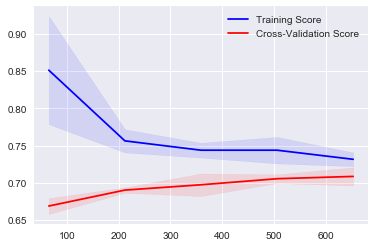

In [46]:
train_sizes, train_scores, valid_scores = learning_curve(lr_best, 
                                                         X, y, 
                                                         train_sizes=np.linspace(0.1, 1, 5))

plot_learning_curve(train_sizes, train_scores, valid_scores)

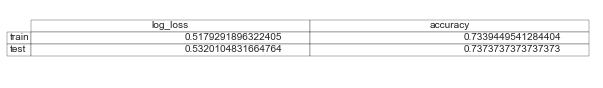

In [47]:
loss_accuracy_report(lr_best, (X, y), (X_tst, y_tst))

# Make Predictions for Stage 1

In [48]:
submission = pd.read_csv('Data/SampleSubmissionStage1.csv')
sub = submission.copy()

peek(submission)

sub['Season']  = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub['WTeamID'] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub['LTeamID'] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.drop(columns=['ID', 'Pred'], inplace=True)

peek(sub)

dataframe shape = (9112, 2)


,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


dataframe shape = (9112, 3)


,Season,WTeamID,LTeamID
0,2014,1107,1110
1,2014,1107,1112
2,2014,1107,1113
3,2014,1107,1124
4,2014,1107,1140


In [49]:
reg_results_name = 'RegularSeasonDetailedResults'
seeds_name = 'NCAATourneySeeds'
ordinals_name = 'MasseyOrdinals_thruSeason2018_Day128'

template = 'Data_2018/Stage2UpdatedDataFiles/{}.csv'

# call full pipeline using paths
df_stg1 = full_pipeline(post_results=sub,
                        reg_results_path=template.format(reg_results_name),
                        seeds_path=template.format(seeds_name),
                        ordinal_path=template.format(ordinals_name))

peek(df_stg1)

X, _ = get_X_y(df_stg1)

dataframe shape = (9112, 33)


,y,d_Wins,d_Score_for,d_Score_against,d_Ast_against,d_Ast_for,d_Blk_against,d_Blk_for,d_DR_against,d_DR_for,...,d_OR_against,d_OR_for,d_PF_against,d_PF_for,d_Stl_against,d_Stl_for,d_TO_against,d_TO_for,d_Seed,d_MOR
0,1,-0.062500,2.093750,5.218750,2.250000,-4.062500,0.593750,-0.375000,2.281250,1.281250,...,0.156250,3.218750,1.625000,0.031250,-1.187500,-0.500000,-0.156250,-1.343750,1.0,28.852123
1,1,-0.319853,-7.027574,5.696691,3.167279,-4.025735,-0.145221,-1.172794,0.387868,-2.075368,...,0.702206,-2.244485,0.632353,0.808824,1.079044,-0.351103,-0.443015,2.183824,15.0,193.140556
2,1,-0.093750,-9.000000,-5.031250,0.781250,-3.125000,-1.031250,-2.593750,-4.843750,-2.968750,...,-1.781250,1.906250,-0.562500,-2.031250,0.281250,0.375000,-0.062500,1.156250,6.0,156.211567
3,1,-0.104167,-7.756629,-4.550189,-2.989583,-3.452652,0.213068,-2.604167,1.230114,0.158144,...,-1.850379,-3.838068,0.401515,-0.295455,0.510417,0.440341,1.665720,0.837121,10.0,177.043192
4,1,-0.104167,-18.180871,-13.701705,-2.232008,-4.573864,-1.241477,0.032197,-3.072917,-3.569129,...,-1.214015,-2.959280,-3.477273,-2.325758,-0.368371,-1.589962,-0.546402,1.140152,6.0,164.625915


X.shape      = (9112, 32) 
y.shape      = (9112,)


In [50]:
yhat = lr_best.predict_proba(X)
print(yhat.shape)
print(yhat[0:5])

(9112, 2)
[[0.57418894 0.42581106]
 [0.97127249 0.02872751]
 [0.80163142 0.19836858]
 [0.90205111 0.09794889]
 [0.85782887 0.14217113]]


In [51]:
submission['Pred'] = yhat[:, 1]
submission.to_csv('submissions/4opposite.csv', index=False)
peek(submission)

dataframe shape = (9112, 2)


,ID,Pred
0,2014_1107_1110,0.425811
1,2014_1107_1112,0.028728
2,2014_1107_1113,0.198369
3,2014_1107_1124,0.097949
4,2014_1107_1140,0.142171


# Make Predictions for 2018

In [52]:
submission = pd.read_csv('Data/SampleSubmissionStage2.csv')
sub = submission.copy()

peek(submission)

sub['Season']  = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub['WTeamID'] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub['LTeamID'] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.drop(columns=['ID', 'Pred'], inplace=True)

peek(sub)

dataframe shape = (2278, 2)


,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


dataframe shape = (2278, 3)


,Season,WTeamID,LTeamID
0,2018,1104,1112
1,2018,1104,1113
2,2018,1104,1116
3,2018,1104,1120
4,2018,1104,1137


In [53]:
reg_results_name = 'RegularSeasonDetailedResults'
seeds_name = 'NCAATourneySeeds'
ordinals_name = 'MasseyOrdinals_thruSeason2018_Day128'

template = 'Data_2018/Stage2UpdatedDataFiles/{}.csv'

# call full pipeline using paths
df_pipe = full_pipeline(post_results=sub,
                        reg_results_path=template.format(reg_results_name),
                        seeds_path=template.format(seeds_name),
                        ordinal_path=template.format(ordinals_name))

peek(df_pipe)

X, _ = get_X_y(df_pipe)

dataframe shape = (2278, 33)


,y,d_Wins,d_Score_for,d_Score_against,d_Ast_against,d_Ast_for,d_Blk_against,d_Blk_for,d_DR_against,d_DR_for,...,d_OR_against,d_OR_for,d_PF_against,d_PF_for,d_Stl_against,d_Stl_for,d_TO_against,d_TO_for,d_Seed,d_MOR
0,1,-0.235294,-8.529412,-1.205882,-1.029412,-2.705882,1.117647,0.911765,4.382353,-0.352941,...,2.705882,0.000000,0.088235,1.500000,0.411765,1.441176,1.529412,1.852941,5.0,19.571895
1,1,-0.086338,-11.163188,-5.351992,-3.511385,-1.631879,0.248577,1.889943,-0.854839,0.942125,...,0.362429,0.126186,-1.739089,0.064516,1.201139,-0.168880,-1.759013,3.437381,-2.0,11.945261
2,1,-0.117647,-8.735294,-5.558824,-1.970588,-1.941176,0.088235,0.852941,0.029412,1.676471,...,0.235294,-0.147059,0.500000,-1.205882,1.823529,0.176471,-0.823529,3.147059,2.0,28.004902
3,1,-0.222426,-11.022059,-3.341912,-1.194853,-1.908088,0.483456,0.064338,-0.062500,0.233456,...,1.338235,-2.095588,-0.685662,-0.875000,0.431985,-1.025735,-2.073529,1.897059,5.0,27.088235
4,1,-0.176471,-8.794118,-2.882353,-0.941176,-1.941176,0.529412,1.029412,-0.441176,-1.235294,...,1.235294,0.676471,-1.205882,0.411765,-0.088235,0.794118,0.588235,1.529412,-5.0,-45.430556


X.shape      = (2278, 32) 
y.shape      = (2278,)


In [54]:
yhat = lr_best.predict_proba(X)
print(yhat.shape)
print(yhat[0:5])

(2278, 2)
[[0.78538323 0.21461677]
 [0.64841348 0.35158652]
 [0.73972329 0.26027671]
 [0.84009569 0.15990431]
 [0.36658884 0.63341116]]


In [55]:
submission['Pred'] = yhat[:, 1]
submission.to_csv('submissions/7opposite.csv', index=False)
peek(submission)

dataframe shape = (2278, 2)


,ID,Pred
0,2018_1104_1112,0.214617
1,2018_1104_1113,0.351587
2,2018_1104_1116,0.260277
3,2018_1104_1120,0.159904
4,2018_1104_1137,0.633411
